In [4]:
import os
import json

def merge_json_files(folder_path, output_file):
    merged_data = []

    # 遍历文件夹中的所有文件
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            # 打开并读取JSON文件
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                # 检查并提取字典中的内容
                merged_data.extend(data)

    # 将合并后的数据写入输出文件
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(merged_data, f, ensure_ascii=False, indent=4)

# 使用示例
folder_path = '/home/qiang/projects/Digital_mental_health/Dataset/Event_Extraction/GAS2SPAS'  # 请替换为你的文件夹路径
output_file = 'GAS_SPAS_800.json'  # 输出的合并文件名
merge_json_files(folder_path, output_file)

In [1]:
from langchain.llms import Ollama
import json
import os
import pandas as pd
from tqdm import tqdm
llm = Ollama(model="llama3:70b")


prompt_few_shot="An event is defined as any stimulus that an individual\'s \
                environment or within that individual(e.g. thoughts of feelings) that has a good or bad effect from the individual\'s \
                point of view. Events can be mental(e.g. I was afraid), social(e.g. I got a pay raise) or physical(e.g. I got in a car accident).\
                Events should be unambiguously good or bad from the individual\'s point of view and may occur in the past, present or hypothetical future.  \
                Please analyze and determine the provided events. We should retain events that are unfavorable for the participants, i.e., bad events. \
                These events should not state facts and one's emotion or pose questions but rather describe a trigger for a bad situation for the participants. \
                Please keep such events and rewrite them into concise and fluent versions. For events that do not meet the requirements, please output:None\
                If there is no event in the post, you should output:\"Event:None\"\
                Please refer to the examples I gave:\
                <example>\
                Event: I snore REALLY loudly and sound like I'm not breathing, which means I must be completely unhealthy and will probably die young from some obscure disease, and no one will ever want to sleep next to me again.\
                Event: I snore really loudly and sound like I'm not breathing.\
                </example>\
                <example>\
                Event: I'm unable to work due to worsening disabilities and severe health issues, which means my whole life is basically over - no career success, no financial stability, no social status, and no hope for a better future.\
                Event: I'm unable to work due to worsening disabilities and severe health issues.\
                </example>\
                <example>\
                Event: why are you sad?\
                Event: None\
                </example>\
                <example>\
                Event: I bet you received lots of hit from that tweet; at work i cannot, wish i could\
                Event: I received hit from that tweet\
                </example>\
                <example>\
                Event: I`m so sad, really really sad\
                Event: None\
                </example>\
                You should answer with a specific format. For example, you should output:\"Event:...\"\
                Please understand what is event that we need from above explanation and extract the main event from the following paragraph:"
          

def event_extraction(input_file, output_folder,posts):
    data_list = []

    for data in tqdm(posts, desc="Processing Event"):
        try:
            prompt=prompt_few_shot+str(data)
        except:
            print("some errors")
        res = llm.predict(prompt)
        result_str = res.split("Event:", 1)[-1].strip()
        data_res_dict = {
            "Post": data,
            "Event": result_str
        }
        data_list.append(data_res_dict)

    output_json_path = os.path.join(output_folder, os.path.basename(input_file).split('.')[0]+'_event_extraction.json')


    with open(output_json_path, 'w') as json_file:
        json.dump(data_list, json_file, indent=4)


def extract_text_in_json(json_file):
    with open(json_file, 'r') as file:
        try:
            data = json.load(file)
        except:
            print("error")
        Post = [o["Post"] for o in data]
        # print(events)
        return Post

def extract_text_column(csv_file_path):
    # 加载CSV文件
    data = pd.read_csv(csv_file_path, encoding='latin1')
    
    # 检查"text"列是否存在于DataFrame中
    if 'text' in data.columns:
        # 提取"text"列
        text_data = data['text']
        return text_data
    else:
        raise ValueError("The CSV file does not contain a 'text' column.")

# 指定CSV文件的路径
csv_file_path = '/home/qiang/projects/Digital_mental_health/Dataset/Event_Extraction/GAS2SPAS/GAS_SPAS_800.json'
output_folder='/home/qiang/projects/Digital_mental_health/Dataset/Event_Extraction/GAS2SPAS/GAS2SPAS_event'
# 调用函数并打印结果
try:
    text_column = extract_text_in_json(csv_file_path)
    event_extraction(csv_file_path, output_folder, text_column)
except Exception as e:
    print(e)

print("处理完成。")


Processing Event: 100%|██████████| 2111/2111 [40:23<00:00,  1.15s/it]

处理完成。


添加ID

In [2]:
import json

# 读取JSON文件
with open('/home/qiang/projects/Digital_mental_health/Dataset/Event_Extraction/GAS2SPAS/GAS2SPAS_event/GAS_SPAS_800_event_extraction.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# 为每个元素添加唯一的ID
for i, element in enumerate(data, start=1):
    element['ID'] = f"{i:05d}"

# 将更新后的数据写回JSON文件
with open('/home/qiang/projects/Digital_mental_health/Dataset/Event_Extraction/GAS2SPAS/GAS2SPAS_event/GAS_SPAS_800_event_extraction.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

print("IDs have been added successfully.")

IDs have been added successfully.


In [3]:
import json
from sentence_transformers import SentenceTransformer, util
from collections import defaultdict

# 加载JSON文件
with open('/home/qiang/projects/Digital_mental_health/Dataset/Event_Extraction/GAS2SPAS/GAS2SPAS_event/GAS_SPAS_800_event_extraction.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# 提取事件和ID
events = [(item["ID"], item["Event"]) for item in data]

# 初始化模型
model = SentenceTransformer('all-MiniLM-L6-v2')

# 计算事件的句子嵌入
embeddings = model.encode([event[1] for event in events], convert_to_tensor=True)

# 计算相似度矩阵
similarities = util.pytorch_cos_sim(embeddings, embeddings)

# 聚类相似事件
clusters = defaultdict(list)
visited = set()

# 设置相似度阈值
threshold = 0.6

for i in range(len(events)):
    if i in visited:
        continue
    cluster = []
    for j in range(len(events)):
        if i != j and similarities[i][j] > threshold:
            cluster.append({
                "ID": events[j][0],
                "Event": events[j][1],
                "Similarity_Score": similarities[i][j].item()
            })
            visited.add(j)
    if cluster:
        # cluster.append({
        #     "ID": events[i][0],
        #     "Event": events[i][1],
        #     "Similarity_Score": 1.0  # 自身与自身的相似度为1
        # })
        clusters[f"Cluster_{i}"] = cluster
    visited.add(i)

# 保存结果到新的JSON文件
with open('/home/qiang/projects/Digital_mental_health/Dataset/Event_Extraction/GAS2SPAS/GAS2SPAS_event/GAS_SPAS_800_event_extraction_clustered.json', 'w', encoding='utf-8') as f:
    json.dump(clusters, f, ensure_ascii=False, indent=4)

print("Clustering complete. Results saved to clustered_events.json")


/opt/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-09-16 16:28:37.101915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 16:28:37.137165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 16:28:37.147454: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-16 16:28:37.213174: I tensorflow/core/platform/cpu_feature_guard.c

Clustering complete. Results saved to clustered_events.json


In [4]:
import json

def extract_ids_from_json1(json1_data):
    """从第一个JSON文件中提取所有的ID"""
    ids = set()
    for cluster_key, events in json1_data.items():
        for event in events:
            ids.add(event.get("ID"))
    return ids

def remove_elements_by_id(json2_data, ids_to_remove):
    """从第二个JSON文件中删除包含指定ID的元素"""
    filtered_json2_data = [item for item in json2_data if item.get("ID") not in ids_to_remove]
    return filtered_json2_data

# 读取第一个JSON文件
with open('/home/qiang/projects/Digital_mental_health/Dataset/Event_Extraction/GAS2SPAS/GAS2SPAS_event/GAS_SPAS_800_event_extraction_clustered.json', 'r') as file1:
    json1_data = json.load(file1)

# 读取第二个JSON文件
with open('/home/qiang/projects/Digital_mental_health/Dataset/Event_Extraction/GAS2SPAS/GAS2SPAS_event/GAS_SPAS_800_event_extraction.json', 'r') as file2:
    json2_data = json.load(file2)

# 提取第一个JSON文件中的所有ID
ids_to_remove = extract_ids_from_json1(json1_data)

# 删除第二个JSON文件中包含这些ID的元素
updated_json2_data = remove_elements_by_id(json2_data, ids_to_remove)

# 将结果写入新的JSON文件
with open('/home/qiang/projects/Digital_mental_health/Dataset/Event_Extraction/GAS2SPAS/GAS2SPAS_event/GAS_SPAS_800_event_extraction_clustered_deduplication.json', 'w') as file:
    json.dump(updated_json2_data, file, indent=4)

print("处理完成，结果已保存到 deduplication.json")


处理完成，结果已保存到 deduplication.json


In [3]:
import json
import re

# 定义分类关键词
categories = {
    'Relationship': ['family', 'friends','friend','breakup', 'marriage', 'partner', 'conflict','fight','reject','overlook','betray','alone','invited','affection','closeness','lying'
                     'relationship','child','daughter','mother','mom', 'husband','wife','sister', 'grandfather','grandmother','parent','girlfriend','boyfriend',  
                     'infidelity', 'connect','argument', 'broke my heart', 'unattractive', 'rejection', 'abandoned', 'broke up', 'date', 'ignoredl', 'disrespected', 'lonely', 
                     'unloved', 'isolation', 'understand', 'appreciate', 'vindictive', 'divorce','ex', 'nervous', 'guy', 'disowned','overlooked','betrayed','relationship','breaking up'
                      'conflicting','isolated', 'apart','embarrass','complained','cheating'],
    'Health and Medication': ['illness', 'injury', 'medication', 'hospital', 'mental health', 'anxiety', 'depression','motivation', 'pains', 'sickness', 
                              'alcoholism', 'sick', 'suicidal', 'panic', 'attack', 'cancer', 'pain', 'allergic', 'brain fog',  'weed', 'drug', 'sunburn', 'poisoned', 
                              'stress', 'diagnose', 'diagnosed', 'traumatic', 'asthma', 'health',  'cold', 'congenital glaucoma', 'unaffordable', 'snore', 'CPTSD',
                              'suicide-related', 'sleeping', 'stressed', 'worried', 'anxiety', 'dying', 'breakdown',  'mental', 'illnesses', 'headache','PTSD', 'tumor',
                              ,'sleep','nightmare','crying','tired','control','side effect','surgery'],
    'Financial Stability': ['money', 'debt', 'salary', 'income', 'expenses', 'poverty', 'financial problems','homeless', 'wasted',  'credit', 'bill', 'pay', 'afford',
                             'payment', 'debts','rent', 'overdue','tuition', 'expensive', 'transaction', 'bills'],
    'Jobs and Careers': ['job', 'jobs', 'work', 'career', 'boss', 'colleague', 'promotion', 'unemployment', 'workplace','school', 'role', 
                         'graduate', 'college', 'grumpiness', 'intimidation', 'applied', 'finals', 'coworkers', 'workload', 'meeting', 'progress', 'GPA', 'academy', 'worked',
                         'overshadowed','laid off','fired','sold'],
    'Bias or Abuse': ['discrimination', 'harassment', 'abuse', 'bias', 'sexism', 'racism','Raped', 'fat', 'humiliate', 'judge', 'insecurities', 'victim', 'criticism',
                       'abused', 'criticized', 'controlled', 'cruel', 'bullied', 'hatred',  'body-shamed', 'scars', 'laughed', 'worthless', 'insulted', 
                       'blew up', 'blamed', 'abusive', 'harm', 'insulted', 'insult', 'harassed', 'violent', 'abuser', 'sex', 'labeled', 'asshole','nightmare','irritable','ghosted','panic',
                       'terrible','hurts','berates','flashbacks','triggered'],
    'Incompetent': ['On time', 'unable', 'forgot', 'can\'t', 'failure', 'disappointment', 'poorly','failed', 'cloudn\'t',
                     'expectations', 'performance', 'impossible', 'incompetent', 'ability', 'disabilities', 'stupid', 'overwelmed', 'struggling','fail','bad' ]
    # 'Others': []
}

# 关键词匹配函数，返回类别
def label_text(text):
    labels = []
    for category, keywords in categories.items():
        for keyword in keywords:
            if re.search(r'\b' + keyword + r'\b', text.lower()):
                labels.append(category)
                break  # 一旦匹配成功可以跳出循环，加速处理
    if not labels:
        labels.append('Others')
    return labels  # 返回第一个匹配的类别

# 读取原始JSON文件
with open('/home/qiang/projects/Digital_mental_health/Dataset/Event_Extraction/GAS2SPAS/GAS2SPAS_event/GAS_SPAS_800_event_extraction_clustered_deduplication_1234.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# 为每个element添加Label
for element in data:
    event_text = element.get('Event', '')
    label = label_text(event_text)
    element['Label'] = label  # 添加类别标签

# 将新的内容写入新的JSON文件
with open('GAS_SPAS_800_event_extraction_clustered_deduplication_1234_label.json', 'w', encoding='utf-8') as file:
    json.dump(data, file, indent=4, ensure_ascii=False)

print("Labeling complete and saved to 'output_labeled.json'.")


Labeling complete and saved to 'output_labeled.json'.


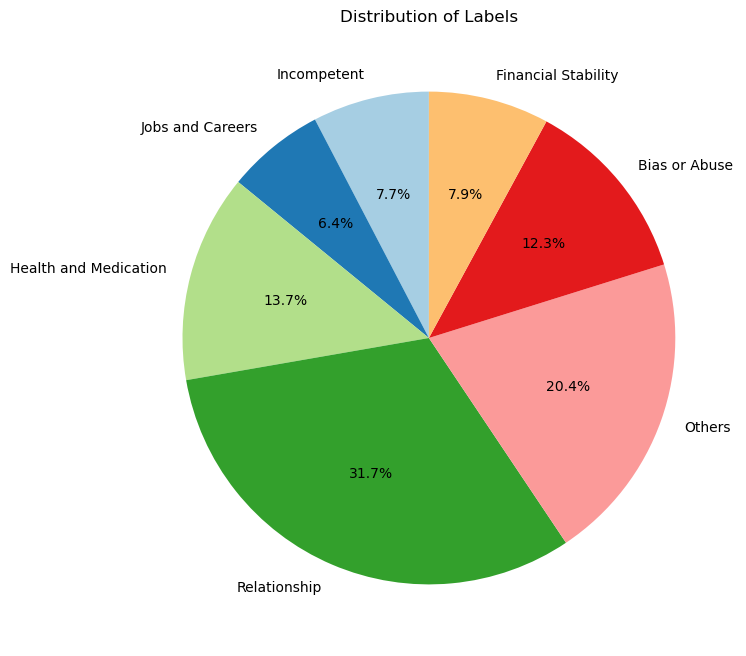

In [1]:
import json
import matplotlib.pyplot as plt
from collections import Counter

# 假设json文件的路径为'file.json'
file_path = '/home/qiang/projects/Digital_mental_health/Dataset/Event_Extraction/GAS2SPAS/GAS_SPAS_800_event_extraction_clustered_deduplication_1234_label.json'

# 读取json文件
with open(file_path, 'r') as file:
    data = json.load(file)

# 统计Label中不同类别的数量
label_counts = Counter()
for entry in data:
    label_counts.update(entry["Label"])

# 获取类别和对应的数量
labels = list(label_counts.keys())
counts = list(label_counts.values())

# 绘制饼状图
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of Labels')
plt.show()
